## Dive into Deep Learning 5.7.10

In [1]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""
    pass

def extract(filename, folder):
    """Extract a zip/tar file into folder."""
    pass

In [3]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [4]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [5]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [6]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [7]:
data.preprocess()
data.train.shape

(1460, 331)

In [8]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

In [9]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

average validation log mse = 0.16430941820144654


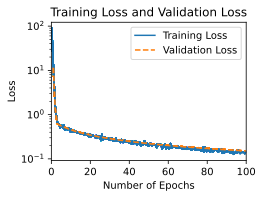

In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.lazy")

trainer = d2l.Trainer(max_epochs=100)
models = k_fold(trainer, data, k=10, lr=0.001)

plt.title('Training Loss and Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

legend_labels = ['Training Loss', 'Validation Loss']
legend_colors = ['#1f77b4', '#ff7f0e']
legend_handles = [
    Line2D([0], [0], linestyle='-', color=legend_colors[0]),
    Line2D([0], [0], linestyle='--', color=legend_colors[1]),
]
plt.legend(legend_handles, legend_labels)
plt.show()

In [20]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('/Users/SongYoungOh/Downloads/submission.csv', index=False)

### 5.7.10 Exercise 1
#### Submit your predictions for this section to Kaggle. How good are they?

> My submission got a public score of 0.39811, which gave me a rank of 3550. It seems not super great.

### 5.7.10 Exercise 2
#### Is it always a good idea to replace missing values by a mean? Hint: can you construct a situation where the values are not missing at random?

> No, replacing missing values by the mean would be often very convenient, but it is not always a good idea especially when the missing values are outliers so they are likely to have highly extreme values for some reason. In such case, imputing missing values just with the mean would not be appropriate.

### 5.7.10 Exercise 3
#### Improve the score by tuning the hyperparameters through K-fold cross-validation.

average validation log mse = 0.4984641361236573


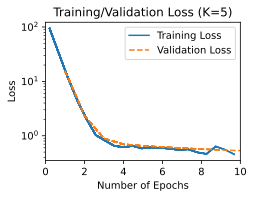

In [27]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.lazy")

trainer = d2l.Trainer(max_epochs=10)
models_5 = k_fold(trainer, data, k=5, lr=0.001)

plt.title('Training/Validation Loss (K=5)')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

legend_labels = ['Training Loss', 'Validation Loss']
legend_colors = ['#1f77b4', '#ff7f0e']
legend_handles = [
    Line2D([0], [0], linestyle='-', color=legend_colors[0]),
    Line2D([0], [0], linestyle='--', color=legend_colors[1])
]
plt.legend(legend_handles, legend_labels)
plt.show()

average validation log mse = 0.43550219287474945


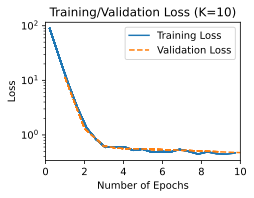

In [28]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.lazy")

models_10 = k_fold(trainer, data, k=10, lr=0.001)

plt.title('Training/Validation Loss (K=10)')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

legend_labels = ['Training Loss', 'Validation Loss']
legend_colors = ['#1f77b4', '#ff7f0e']
legend_handles = [
    Line2D([0], [0], linestyle='-', color=legend_colors[0]),
    Line2D([0], [0], linestyle='--', color=legend_colors[1])
]
plt.legend(legend_handles, legend_labels)
plt.show()

average validation log mse = 0.4680377950270971


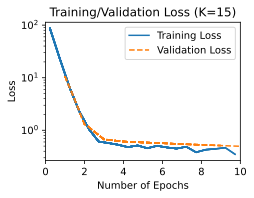

In [29]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.lazy")

models_15 = k_fold(trainer, data, k=15, lr=0.001)

plt.title('Training/Validation Loss (K=15)')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

legend_labels = ['Training Loss', 'Validation Loss']
legend_colors = ['#1f77b4', '#ff7f0e']
legend_handles = [
    Line2D([0], [0], linestyle='-', color=legend_colors[0]),
    Line2D([0], [0], linestyle='--', color=legend_colors[1])
]
plt.legend(legend_handles, legend_labels)
plt.show()

average validation log mse = 0.4331003401428461


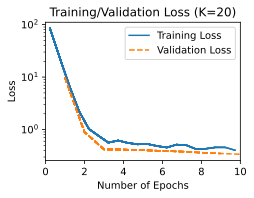

In [30]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.lazy")

models_20 = k_fold(trainer, data, k=20, lr=0.001)

plt.title('Training/Validation Loss (K=20)')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

legend_labels = ['Training Loss', 'Validation Loss']
legend_colors = ['#1f77b4', '#ff7f0e']
legend_handles = [
    Line2D([0], [0], linestyle='-', color=legend_colors[0]),
    Line2D([0], [0], linestyle='--', color=legend_colors[1])
]
plt.legend(legend_handles, legend_labels)
plt.show()

average validation log mse = 0.4675295573472977


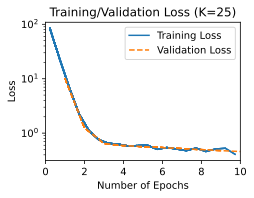

In [31]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.lazy")

models_25 = k_fold(trainer, data, k=25, lr=0.001)

plt.title('Training/Validation Loss (K=25)')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

legend_labels = ['Training Loss', 'Validation Loss']
legend_colors = ['#1f77b4', '#ff7f0e']
legend_handles = [
    Line2D([0], [0], linestyle='-', color=legend_colors[0]),
    Line2D([0], [0], linestyle='--', color=legend_colors[1])
]
plt.legend(legend_handles, legend_labels)
plt.show()

average validation log mse = 0.46058098127444586


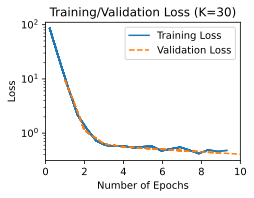

In [32]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.lazy")

models_30 = k_fold(trainer, data, k=30, lr=0.001)

plt.title('Training/Validation Loss (K=30)')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

legend_labels = ['Training Loss', 'Validation Loss']
legend_colors = ['#1f77b4', '#ff7f0e']
legend_handles = [
    Line2D([0], [0], linestyle='-', color=legend_colors[0]),
    Line2D([0], [0], linestyle='--', color=legend_colors[1])
]
plt.legend(legend_handles, legend_labels)
plt.show()

In [18]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models_20]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('/Users/SongYoungOh/Downloads/submission.csv', index=False)